Authors: Jai 20045247, Dennis Kolomiyets 20250762
         

# Drive Link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS4168PROJECTGROUP12

Mounted at /content/drive
/content/drive/MyDrive/CS4168PROJECTGROUP12


# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.svm import SVR
from sklearn.decomposition import FastICA

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dataset

In [ ]:
file_path = './steel_industry_data_excerpt.csv'
data = pd.read_csv(file_path)

### Head

In [ ]:
data.head(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,2018-01-01 02:30:00,3.78,4.72,0.00,0.0,62.51,100.00,9000,Weekday,Monday
1,2018-01-01 04:15:00,3.28,3.82,0.00,0.0,65.14,100.00,15300,Weekday,Monday
2,2018-01-01 05:45:00,3.28,3.49,0.00,0.0,68.48,100.00,20700,Weekday,Monday
3,2018-01-01 10:00:00,3.64,0.00,16.88,0.0,100.00,21.08,36000,Weekday,Monday
4,2018-01-01 10:30:00,3.71,0.00,18.00,0.0,100.00,20.19,37800,Weekday,Monday


### Tail

In [ ]:
data.tail(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
2185,2018-12-31 06:45:00,3.02,2.12,0.11,0.0,81.85,99.93,24300,Weekday,Monday
2186,2018-12-31 09:45:00,3.17,0.00,14.65,0.0,100.00,21.15,35100,Weekday,Monday
2187,2018-12-31 13:45:00,3.31,0.00,13.68,0.0,100.00,23.52,49500,Weekday,Monday
2188,2018-12-31 20:00:00,4.14,0.00,20.09,0.0,100.00,20.18,72000,Weekday,Monday
2189,2018-12-31 22:45:00,3.82,4.54,0.00,0.0,64.38,100.00,81900,Weekday,Monday


# Data Preparation

In [ ]:
y = data['Usage_kWh']
X = data.drop(['Usage_kWh','date'], axis=1)

In [ ]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']),
        ("categorical", OneHotEncoder(sparse_output=False), ['WeekStatus', 'Day_of_week'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [ ]:
X_transformed = preprocess_pipeline.fit_transform(X)

In [ ]:
X_transformed.head(5)

,no_outliers__Lagging_Current_Reactive.Power_kVarh,no_outliers__Leading_Current_Reactive_Power_kVarh,no_outliers__CO2(tCO2),no_outliers__Lagging_Current_Power_Factor,no_outliers__Leading_Current_Power_Factor,no_outliers__NSM,categorical__WeekStatus_Weekday,categorical__WeekStatus_Weekend,categorical__Day_of_week_Friday,categorical__Day_of_week_Monday,categorical__Day_of_week_Saturday,categorical__Day_of_week_Sunday,categorical__Day_of_week_Thursday,categorical__Day_of_week_Tuesday,categorical__Day_of_week_Wednesday
0,-0.531611,-0.527125,-0.731532,-0.983264,0.519599,-1.371186,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.585137,-0.527125,-0.731532,-0.842974,0.519599,-1.117302,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.604763,-0.527125,-0.731532,-0.664812,0.519599,-0.899688,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.812324,1.720222,-0.731532,1.016528,-2.039616,-0.283114,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.812324,1.869335,-0.731532,1.016528,-2.068477,-0.210576,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_transformed.tail(5)

,no_outliers__Lagging_Current_Reactive.Power_kVarh,no_outliers__Leading_Current_Reactive_Power_kVarh,no_outliers__CO2(tCO2),no_outliers__Lagging_Current_Power_Factor,no_outliers__Leading_Current_Power_Factor,no_outliers__NSM,categorical__WeekStatus_Weekday,categorical__WeekStatus_Weekend,categorical__Day_of_week_Friday,categorical__Day_of_week_Monday,categorical__Day_of_week_Saturday,categorical__Day_of_week_Sunday,categorical__Day_of_week_Thursday,categorical__Day_of_week_Tuesday,categorical__Day_of_week_Wednesday
2185,-0.686241,-0.512480,-0.731532,0.048370,0.517329,-0.754612,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2186,-0.812324,1.423327,-0.731532,1.016528,-2.037346,-0.319383,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2187,-0.812324,1.294184,-0.731532,1.016528,-1.960492,0.260922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2188,-0.812324,2.147590,-0.731532,1.016528,-2.068801,1.167648,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2189,-0.542316,-0.527125,-0.731532,-0.883514,0.519599,1.566608,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Here we will attempt four different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Independent Component Analysis (ICA)

### Random Forest Pipeline

In order to provide predictions on continuous numerical values that are more accurate, a Random Forest regression pipeline combines the forecasts of many decision trees. Individual predictions are made by each decision tree in the forest after it has been trained on a random subset of the dataset. The final result is then generated by averaging the predictions made by each tree (in the case of regression tasks). Through the capture of many features of the data, this ensemble technique reduces overfitting and boosts the resilience of the model. The Random Forest regressor's overall efficacy is further enhanced by random feature selection and bootstrapping, which are applied during tree construction to increase tree variety.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=10),
        func=np.log,
        inverse_func=np.exp)
    )
])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.990:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 8}


### Linear Regression Pipeline

The goal of a linear regression pipeline is to minimize the discrepancy between the anticipated and actual values by fitting a straight line to the data. The coefficients (slope and intercept) that best suit the training set of data are first determined. After training, the model multiplies the features by the matching coefficients and adds them up to forecast the target variable for fresh data points. In contrast to more adaptable models like Random Forest, Linear Regression may find it difficult to identify complicated patterns in the data due to the simplicity of the linear connection.

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log,
                           inverse_func=np.exp)
                       )
                      ]
               )

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.639:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ttr__regressor__fit_intercept': False}


### KNN Pipeline

K-Nearest Neighbors (KNN) regression pipeline works by finding the K data points that are nearest to the query point using a selected distance metric (usually the Euclidean distance) in the feature space. After identifying these nearest neighbors, the model averages the target values of its K nearest neighbors to estimate the target value for the query location. According to this method, comparable data points in the feature space typically have comparable goal values. Although KNN regression is easy to comprehend and apply, its success is highly dependent on the dataset's properties and the choice of K. It can also have trouble processing noisy or high-dimensional data.

In [ ]:
knn_regressor = KNeighborsRegressor()
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=knn_regressor,
        func=np.log,
        inverse_func=np.exp)
    )
])


In [ ]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8]
    },
    {
        'reduce_dim': ['passthrough'],
        'ttr__regressor__n_neighbors': [3, 5, 7],
        'ttr__regressor__weights': ['uniform', 'distance'],
        'ttr__regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.991:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


### Extreme Gradient Boosting Pipeline

A single strong model is created by repeatedly merging several weak predictive model (usually decision tree) into an Extreme Gradient Boosting regression process. The model steadily lowers the total error in each iteration by fitting a new tree to the residuals, or the disparities between the actual and predicted values, of the preceding iteration. To improve model performance and avoid overfitting, XGBoost uses regularization and gradient descent optimization. It is an effective tool for regression problems in a variety of domains because it makes use of ensemble learning's advantages, which include managing non-linear correlations and capturing complicated interactions.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=XGBRegressor(objective='reg:squarederror'),
        func=np.log1p,
        inverse_func=np.expm1)
    )
])


In [ ]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__n_estimators': [100, 200],
        'ttr__regressor__learning_rate': [0.01, 0.1, 0.2],
        'ttr__regressor__max_depth': [3, 5, 7]
    },
    {
        'reduce_dim': [RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': [2, 6, 11],
        'ttr__regressor__n_estimators': [100, 200],
        'ttr__regressor__learning_rate': [0.01, 0.1, 0.2],
        'ttr__regressor__max_depth': [3, 5, 7]
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'ttr__regressor__n_estimators': [100, 200],
        'ttr__regressor__learning_rate': [0.01, 0.1, 0.2],
        'ttr__regressor__max_depth': [3, 5, 7]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_

Best CV score = 0.992:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ttr__regressor__learning_rate': 0.2, 'ttr__regressor__max_depth': 3, 'ttr__regressor__n_estimators': 200}


## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [ ]:
def evaluate_model(X_test, y_test, model):
    _predicted_values = model.predict(X_test)
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)
XGB_mse, XGB_mae, XGB_r2 = evaluate_model(X_test, y_test, XGB_best_model)

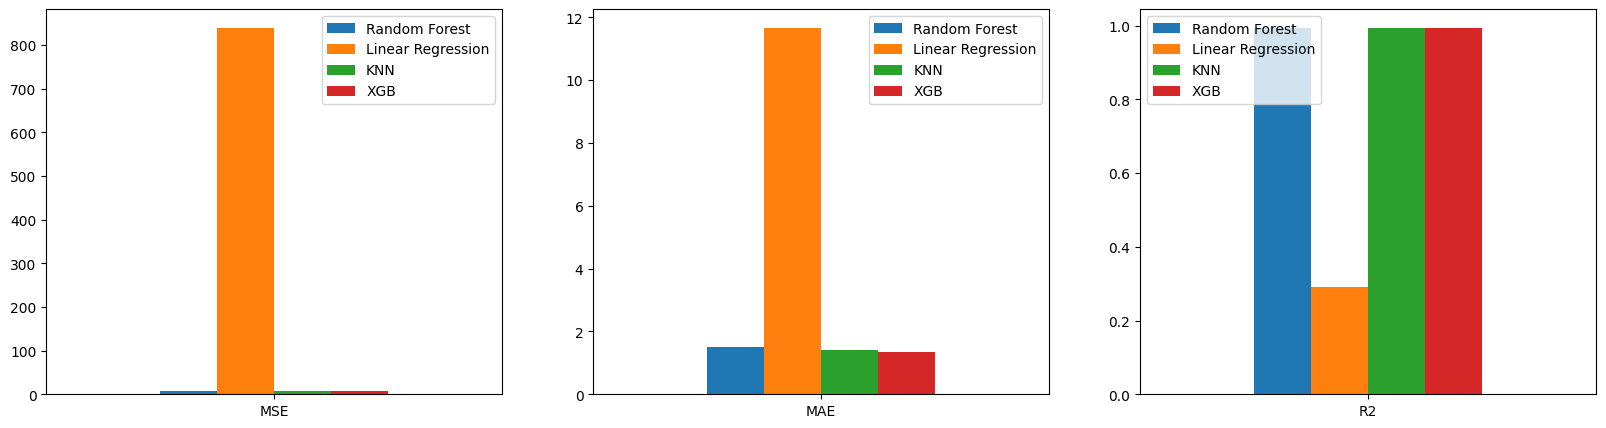

In [ ]:
data_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNN': KNN_mse, 'XGB': XGB_mse}, index=['MSE'])
data_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNN': KNN_mae, 'XGB': XGB_mae}, index=['MAE'])
data_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNN': KNN_r2, 'XGB':XGB_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

data_mse.plot.bar(rot=0, ax=axes[0])
data_mae.plot.bar(rot=0, ax=axes[1])
data_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that XGB is the better regression model with lower MSE and MAE and higher R2.

## Train a Final Model

In [ ]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline,
                     XGB_best_params.get('reduce_dim'),
                     XGBRegressor(**transform(XGB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Store this model on disk.

In [ ]:
filename = 'final_model_reg.sav'
pickle.dump(final_model, open(filename, 'wb'))

New trained model will be stored on disk

#Conclusion
When Looking at the bar plots that were generated in the previous steps, we can conclude that:
Linear Regression was the highest in MSE and MAE while being the lowest in R2, while XGB had lower MSE and the lowest MAE making it the best regression model.  It demonstrates better predictive accuracy, precision, and ability to explain the variance in the target variable compared to the alternative regression models tested.